# Pre-trained Network

This part is dedicated to the usage of a pre-trained convolutional neural network in order to solve the task proposed in this project. <br>
For this purpose, **Xception** pre-trained network is used because it is one of most performing models trained with ImageNet.

## Introduction to Xception

Xception stands for extreme inception, it takes the principles of Inception to an extreme. An **Inception** module computes multiple different transformations over the same input and then finally combining all the output which lets the model decide what features to take and by how much. 

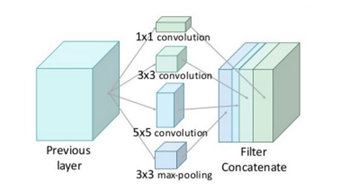

However, this is computationally inefficient because of convolutions. These convolutions not only happen spatially, but also across the depth. So, in each additional filter, it is necessary to perform convolution over the input depth to calculate just a single output map, and because of this, the depth becomes a huge bottleneck in the DNN. This depth can be reduced by doing 1x1 convolution across the depth. This convolution looks across multiple channel's spatial information and compress it down to a lower dimension. Due to this reduction, the researchers of Inception module were able to concatenate different layer transformations in parallel, resulting in DNN that was wide and deep.




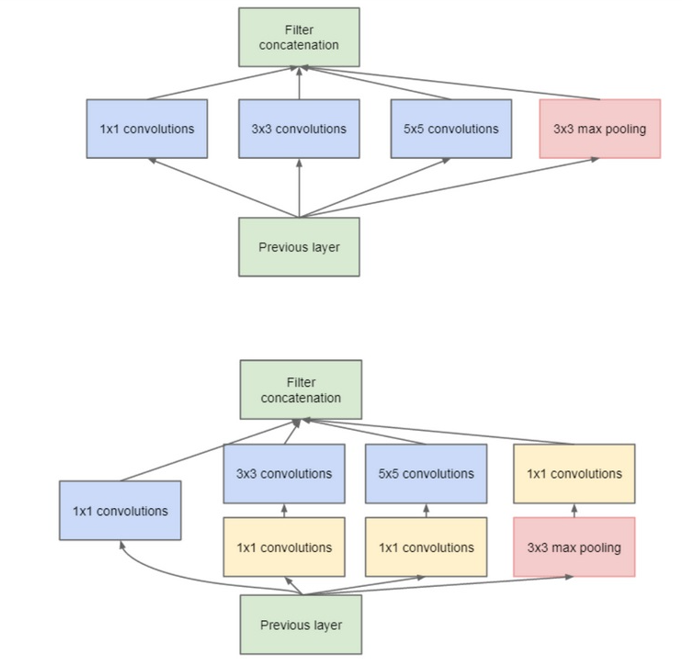

Xception stands for extreme inception, it takes the principles of Inception to an extreme. In Inception, 1x1 convolutions were used to compress the original input, and from each of those input spaces different type of filters are used on each of the depth space. Xception just reverses this step. Instead, it first applies the filters on each of the depth map and then finally compresses the input space using 1x1 convolution by applying it across the depth. 

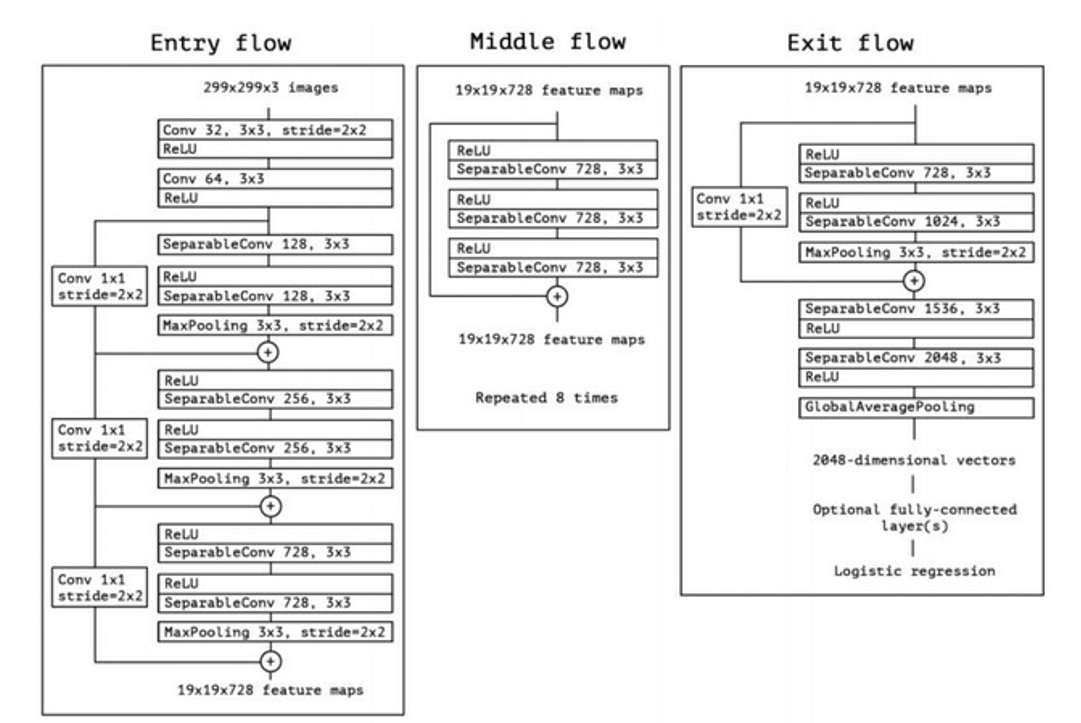

##Set parameters and load data

In [1]:
#Import all the required libraries

import os
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

from google.colab import drive

In [ ]:
# Mount drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Set parameters

#Paths to get the splitted dataset
BASE_PATH='/content/drive/MyDrive/Vigna/'
DATASET_FOLDER_NAME='dataset'

NEW_PATH=os.path.join(BASE_PATH,DATASET_FOLDER_NAME)
NEW_PATH_TRAIN=os.path.join(NEW_PATH,'train')
NEW_PATH_VALIDATION=os.path.join(NEW_PATH,'validation')
NEW_PATH_TEST=os.path.join(NEW_PATH,'test')

MODEL_PATH=os.path.join(BASE_PATH,'models')
HISTORY_PATH=os.path.join(MODEL_PATH,'history')

#Hyperparameters
BATCH_SIZE=32
EPOCHS=50
PATIENCE=5

In [ ]:
#Define Callback to use

def createCustomCallback(save_path,val_to_monitor):
  return [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor=val_to_monitor,
    verbose=1,
    restore_best_weights=True,
    save_best_only=True #Save best model only
    )
  ]

In [ ]:
#Some utility functions

#Function to plot custom graphics to see training performance
#xTra_scale range of values on x - training
#yTra_scale range of values on y - training
#xVal_scale range of values on x - validation
#yVal_scale range of values on y - validation
def plotAccuracyAndLossCurves(history,xTra_scale=np.arange(1, EPOCHS+1, 1),yTra_scale=np.arange(0, 1+0.05, 0.05),xVal_scale=np.arange(1, EPOCHS+1, 1),yVal_scale=np.arange(0, 1, 0.05)):
  plt.figure(figsize=(15,5))
  
  #On training set
  acc_1 = history['accuracy']
  loss_1 = history['loss']
  
  #On validation set
  val_acc_1 = history['val_accuracy']
  val_loss_1 = history['val_loss']

  #History length
  n_epochs=len(historySaved['accuracy'])
  
  epochs = np.arange(1, n_epochs+1, 1)
  plt.grid()
  plt.plot(epochs, acc_1, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc_1, 'r-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.xticks(xTra_scale)
  plt.yticks(yTra_scale)
  plt.figure()

  plt.figure(figsize=(15,5))
  plt.plot(epochs, loss_1, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_1, 'r-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xticks(xVal_scale)
  plt.yticks(yVal_scale)
  plt.legend()
  plt.grid()

  plt.show()


#Function to plot a custom barchar
def drawBarPlot(plt,name,values,title):
  plt.figure(figsize=(15, 5))
  plt.bar(name, values, width = 0.2, color='blue')
  plt.xlabel("Classes misclassified")
  plt.ylabel("No. of misclassification ")
  plt.title(title)
  plt.show()

#Function to have a brief summary of classification error on test dataset
def statErrors(test_dataset,predictions,verbose=False,displayImage=False):
  errorCount=0
  indexErr_List=[]
  
  #Iterate on all the test dataset
  test_val=tf.concat([data_batch for data_batch, labels_batch in test_dataset], axis = 0)
  y_test = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)  

  class_names = test_dataset.class_names

  #Print the status of correct/incorrect predictions.
  if (verbose==True):
      print("predicted || actual");

  map={}
  for i in range (len(class_names)):
    map[class_names[i]]=0

  for indexTest in range(predictions.shape[0]):
      infoStr="";
      actual=class_names[np.argmax(y_test[indexTest])]
      predicted=class_names[np.argmax(predictions[indexTest])]
      if (np.argmax(predictions[indexTest])!=np.argmax(y_test[indexTest])):
          errorCount+=1;
          indexErr_List.append(indexTest)
          infoStr="ERROR ";
          classToMatch=class_names[np.argmax(y_test[indexTest])]
          if classToMatch in map:
            map[classToMatch]=map[classToMatch]+1
         
      if (verbose==True):
        print(str(indexTest)+") "+infoStr+" "+predicted+'||'+actual+": "+str((predictions[indexTest][np.argmax(predictions[indexTest])])*100)+"%");
 
  print ("Total errors :" +str(errorCount)+"/"+str(predictions.shape[0]));

  drawBarPlot(plt,map.keys(),map.values(),'Misclassifications per class')

  IMAGE_PER_RAW=6
  if (displayImage):
    plt.figure(figsize=(20, 40))
    class_names = test_dataset.class_names
    for i in range(len(indexErr_List)):
        index=indexErr_List[i]
        ax = plt.subplot(int(len(indexErr_List)/IMAGE_PER_RAW)+1, IMAGE_PER_RAW, i + 1)
        plt.imshow(test_val[index][:,:,0], cmap='gray')  
        
        perc=round ( (predictions[index][np.argmax(predictions[index])])*100,2)
        percStr=str(perc)+"%"

        plt.title("Pred. "+class_names[np.argmax(predictions[index])]+" conf: "+percStr ,  fontsize=10)
        plt.text(0,600, "Act. "+class_names[np.argmax(y_test[index])], fontSize=12,bbox=dict(facecolor='red', alpha=0.2));
        
        plt.axis("off")


#Plot the confusion matrix and the ROC curve
def evalutation_performance(test_dataset,predictions):

  y_test = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)  
  
  y_testEFF=np.argmax(y_test, axis=1)
  y_pred = np.argmax(predictions, axis=1)

  cm = confusion_matrix(y_testEFF, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)

  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_title('Confusion Matrix');
  #font = {
  #        'weight' : 'bold',
  #        'size'   : 10}

  #plt.rc('font', **font)

  disp.plot(ax=ax,cmap=plt.cm.Blues,values_format='g')
  plt.show()

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(test_dataset.class_names)):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])


  colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','red','brown','pink','green','violet'])
  for i, color in zip(range(len(test_dataset.class_names)), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=2,
          label='ROC curve of class '+str(test_dataset.class_names[i])+' (area = {1:0.4f})'.format(i, roc_auc[i]),
          
      )

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multiclass')
  plt.legend(loc='lower right',prop={'size': 8})
  plt.show()

  plt.figure(2)
  plt.xlim(0, 0.1)
  plt.ylim(0.90, 1.02)
  plt.plot([0, 1], [0, 1], 'k--')

  for i, color in zip(range(len(test_dataset.class_names)), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=2,
          label='ROC curve of class '+str(test_dataset.class_names[i]),    
  )

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve (zoomed in at top left)')
  plt.legend(loc='lower right',prop={'size': 8})
  plt.show()


In [ ]:
#Creating models and history directories
if not os.path.exists(MODEL_PATH):
  os.makedirs(MODEL_PATH)

if not os.path.exists(HISTORY_PATH):
  os.makedirs(HISTORY_PATH)

The Xception network requires as input, images on 3 RGB channels, so the previous pre-processing grayscale operation is not applied here. The rescaling operation is also removed due to limitation in memory of Google Colab account.

In [ ]:
#Load data
train_dataset = image_dataset_from_directory(
    NEW_PATH_TRAIN,
    label_mode='categorical',
    image_size=(480, 640),
    batch_size=BATCH_SIZE
    #color_mode='grayscale'
    )

validation_dataset = image_dataset_from_directory(
    NEW_PATH_VALIDATION,
    label_mode='categorical',
    image_size=(480, 640),
    batch_size=BATCH_SIZE
    #color_mode='grayscale'
    )

test_dataset = image_dataset_from_directory(
    NEW_PATH_TEST,
    labels='inferred',
    shuffle=False,
    label_mode='categorical',
    image_size=(480, 640),
    #color_mode='grayscale',
    batch_size=BATCH_SIZE)

Found 3150 files belonging to 9 classes.
Found 675 files belonging to 9 classes.
Found 675 files belonging to 9 classes.


## Feature Extraction

The Xception model is used to apply one of the transfer learning techniques: feature extraction. The idea is to use the overall trained structure without the final part (fully connected layer) replacing it with a new fully connected layer with a number of neurons equal to number of classes to predict (9). In this way the features learned generically by the first part, also called convolutional base, are reused and the new fully connected layer is trained (ad hoc) for the custom task of this project. The big advantage is to leverage the training job done by others (which probably required a lot of time and a lot of data) and adapt it to the customized problem.

### Experiment 1: first evaluation

In [ ]:
#Pre-trained model
def createPreTrainedExp1():
  return keras.applications.Xception(include_top=False,input_shape=(480, 640, 3),weights="imagenet")

In [ ]:
#Define model structure
def createModelFeatureExtractionExp1():
  inputs = keras.Input(shape=(480, 640, 3))
  preTrained=createPreTrainedExp1()
  x = preTrained(inputs)
  x = layers.Flatten()(x)
  outputs = layers.Dense(9, activation='softmax')(x)
  model = keras.Model(inputs, outputs)

  #Freez the training of weights on pre-trained network
  preTrained.trainable = False

  return model

In [ ]:
#Istantiate the model
model=createModelFeatureExtractionExp1()

model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 xception (Functional)       (None, 15, 20, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 614400)            0         
                                                                 
 dense (Dense)               (None, 9)                 5529609   
                                                                 
Total params: 26,391,089
Trainable params: 5,529,609
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#Set initial learning rate 
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Define a callback
custom_callback=createCustomCallback(os.path.join(MODEL_PATH, 'PreTrainedCNNModel_1.h5'),'val_loss')  

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks = custom_callback
)
#Save history obtained in history folder
with open(HISTORY_PATH+'/history4_1Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 72.9013 - accuracy: 0.7584 
Epoch 1: val_loss improved from inf to 11.05165, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_1.h5
99/99 [==============================] - 1464s 14s/step - loss: 72.9013 - accuracy: 0.7584 - val_loss: 11.0516 - val_accuracy: 0.9481
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 12.3688 - accuracy: 0.9206
Epoch 2: val_loss improved from 11.05165 to 7.74818, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_1.h5
99/99 [==============================] - 120s 1s/step - loss: 12.3688 - accuracy: 0.9206 - val_loss: 7.7482 - val_accuracy: 0.9437
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 9.8448 - accuracy: 0.9321
Epoch 3: val_loss did not improve from 7.74818
99/99 [==============================] - 118s 1s/step - loss: 9.8448 - accuracy: 0.9321 - val_loss: 23.3335 - val_accuracy: 0.8889
Epoch 4/50
99/99 [==

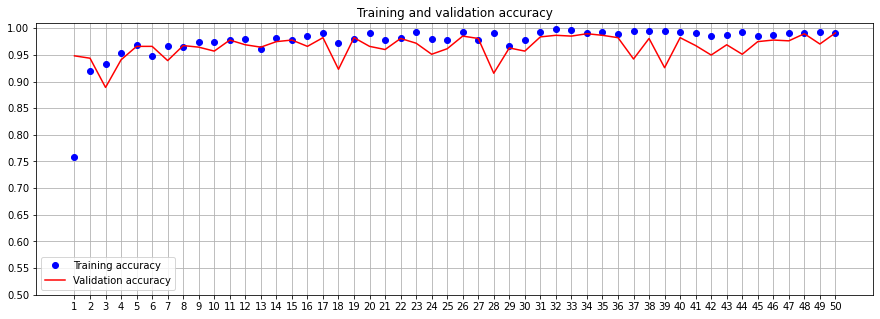

<Figure size 432x288 with 0 Axes>

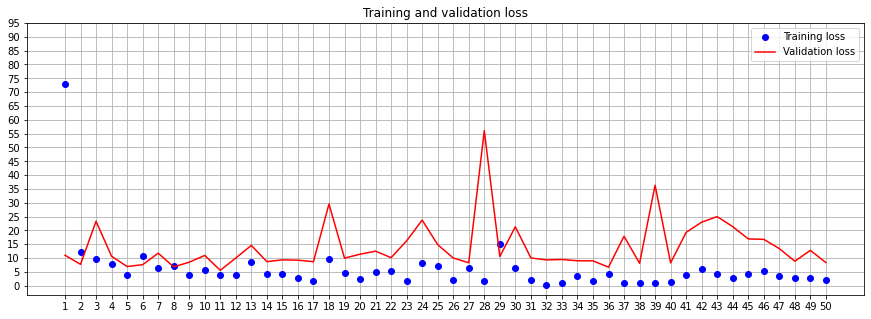

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history4_1Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
    
plotAccuracyAndLossCurves(historySaved,np.arange(1, EPOCHS+1, 1),np.arange(0.5, 1+0.05, 0.05),np.arange(1, EPOCHS+1, 1),np.arange(0, 100, 5))

In [ ]:
#Load the best obtained with low loss epoch 11
model = load_model(MODEL_PATH+"/PreTrainedCNNModel_1.h5") 
predictions = model.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model.evaluate(test_dataset)

22/22 [==============================] - 772s 35s/step - loss: 7.9760 - accuracy: 0.9615


Total errors :26/675


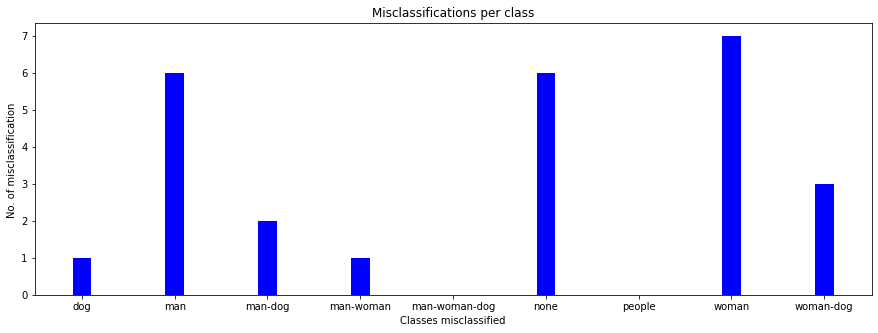

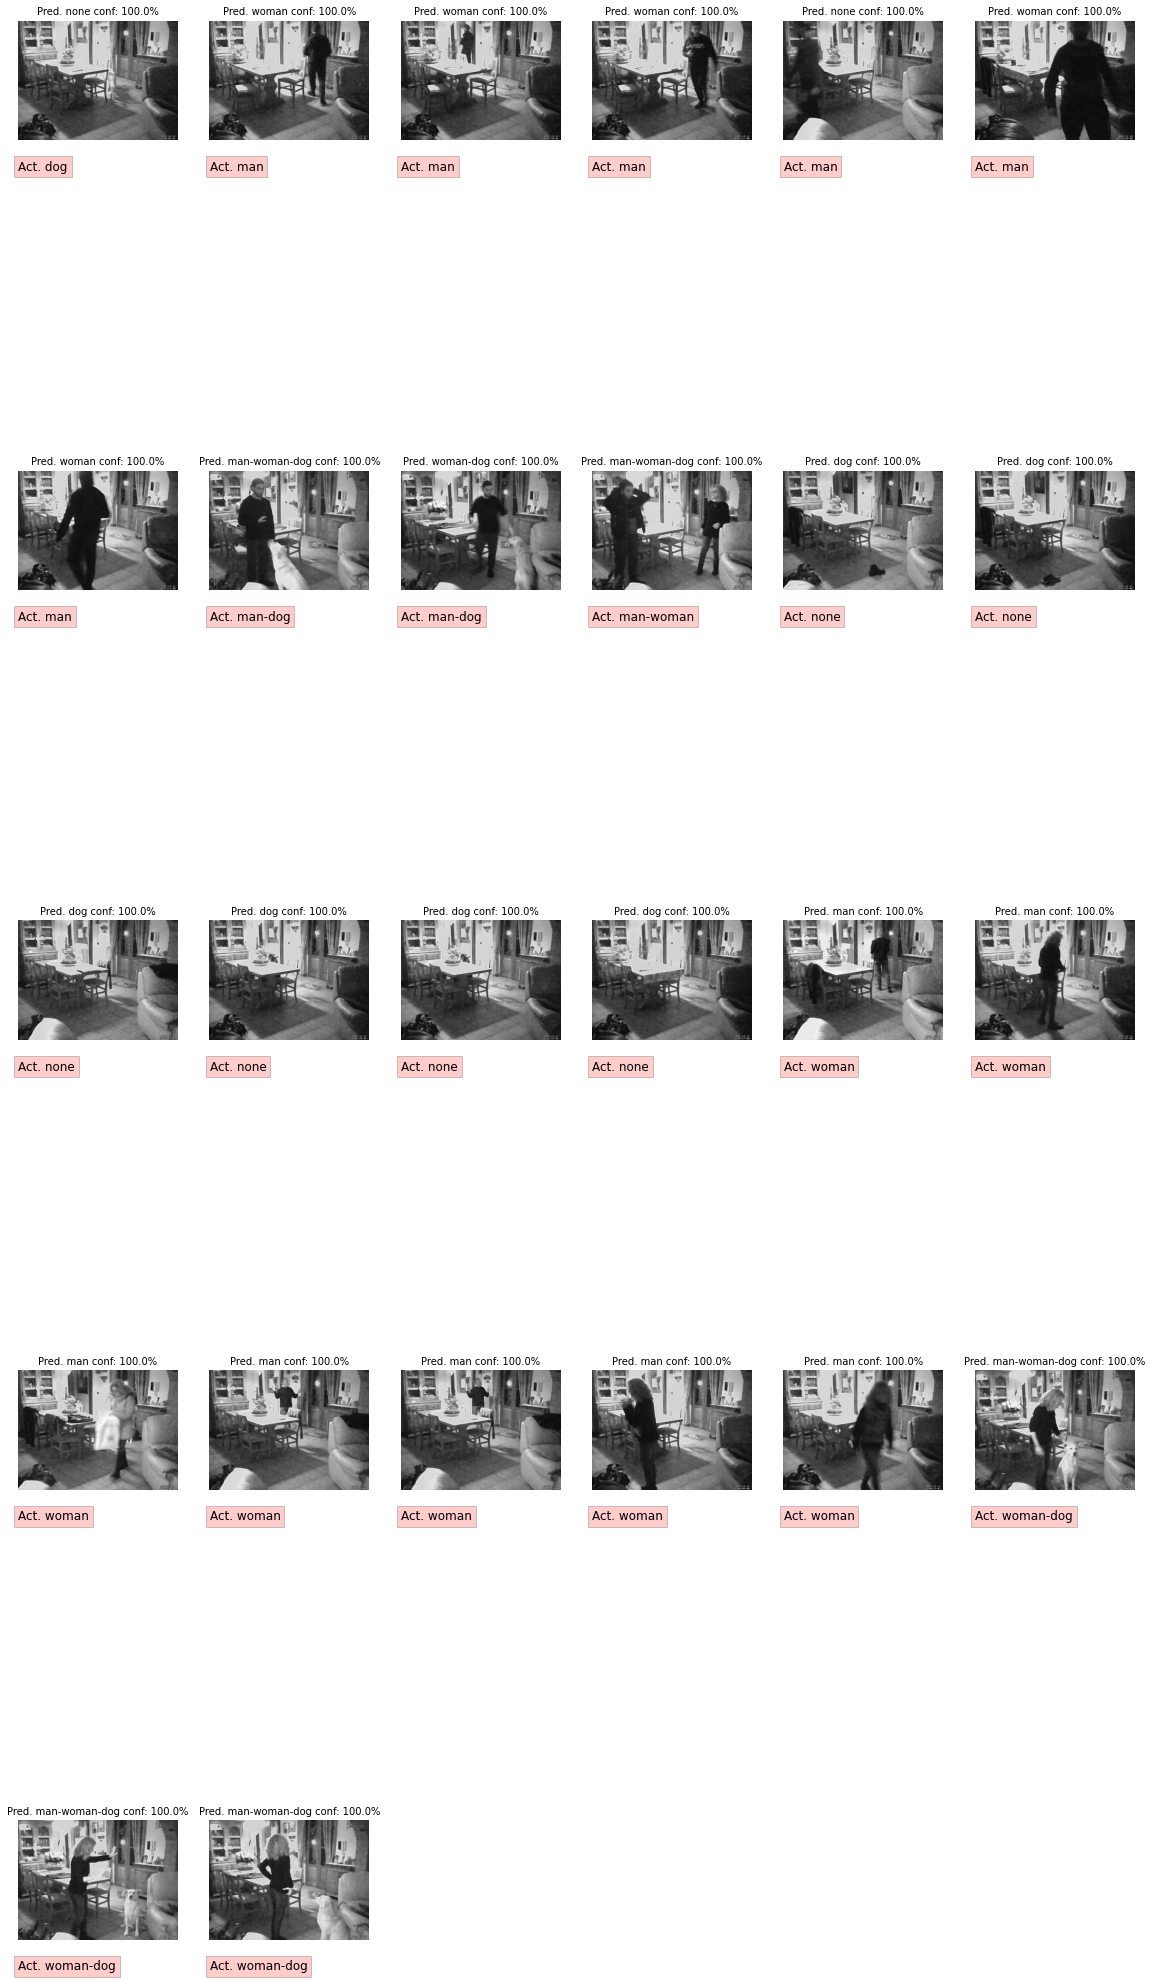

In [ ]:
statErrors(test_dataset,predictions,False,True)

The results obtained evidence that high accuracy can be obtained even with the usage of a pre-trained network. However, the performances obtained are bit worse respect to previous experiments (CNN from scratch). In particular the loss metrics results to be too high. A possible reason of this behaviour is due to mismatch domain of the dataset. 

### Experiment 2: with max-pooling

In the next experiment, in order to try improve this result, in particular to reduce the loss value, it is introduced a max pooling layer applied  to the final layer. This reduces the dimensionality and the parameters to train.

In [ ]:
def createPreTrainedExp2():
  return keras.applications.Xception(
    include_top=False,
    input_shape=(480, 640, 3),
    weights="imagenet",
    pooling="max"
  )

In [ ]:
#Define model structure
def createModelFeatureExtractionExp2():
  inputs = keras.Input(shape=(480, 640, 3))
  preTrained=createPreTrainedExp2()
  x = preTrained(inputs)
  x = layers.Flatten()(x)
  outputs = layers.Dense(9, activation='softmax')(x)

  #Freez the training of weights on pre-trained network
  preTrained.trainable = False

  model = keras.Model(inputs, outputs)
  return model

In [ ]:
#Istantiate the model
model=createModelFeatureExtractionExp2()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 20,879,921
Trainable params: 18,441
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Define a callback
custom_callback=createCustomCallback(os.path.join(MODEL_PATH, 'PreTrainedCNNModel_2.h5'),'val_loss')  

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks = custom_callback
)
#Save history obtained in history folder
with open(HISTORY_PATH+'/history4_2Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 16.9035 - accuracy: 0.3927
Epoch 1: val_loss improved from inf to 7.33235, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_2.h5
99/99 [==============================] - 519s 5s/step - loss: 16.9035 - accuracy: 0.3927 - val_loss: 7.3324 - val_accuracy: 0.5393
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 4.8325 - accuracy: 0.6622
Epoch 2: val_loss improved from 7.33235 to 2.99155, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_2.h5
99/99 [==============================] - 106s 1s/step - loss: 4.8325 - accuracy: 0.6622 - val_loss: 2.9915 - val_accuracy: 0.7393
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 3.5384 - accuracy: 0.7375
Epoch 3: val_loss improved from 2.99155 to 2.20874, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_2.h5
99/99 [==============================] - 100s 1s/step - loss: 3.5384 - accuracy

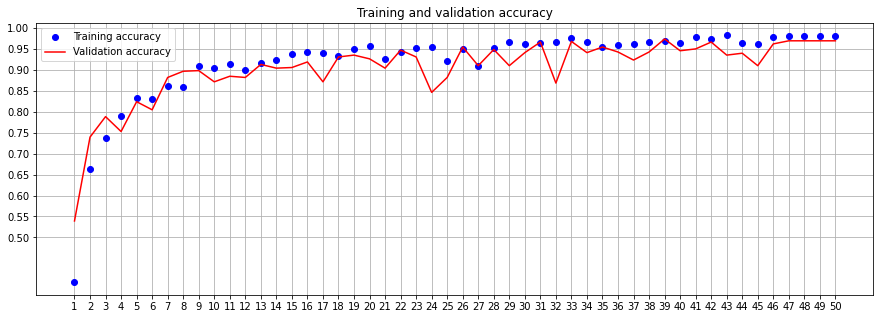

<Figure size 432x288 with 0 Axes>

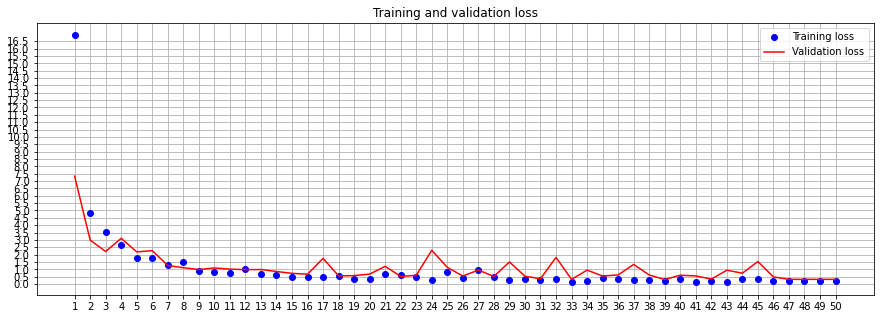

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history4_2Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 

plotAccuracyAndLossCurves(historySaved,np.arange(1, EPOCHS+1, 1),np.arange(0.5, 1+0.05, 0.05),np.arange(1, EPOCHS+1, 1),np.arange(0, 17, 0.5))

In [ ]:
model = load_model(MODEL_PATH+"/PreTrainedCNNModel_2.h5") 
predictions = model.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model.evaluate(test_dataset)

22/22 [==============================] - 664s 30s/step - loss: 0.5822 - accuracy: 0.9437


Total errors :38/675


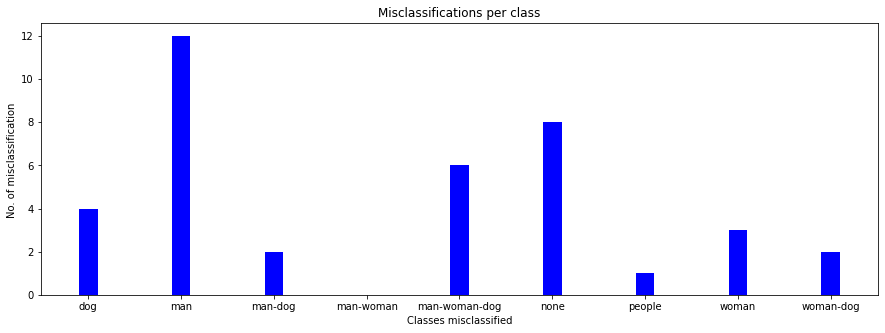

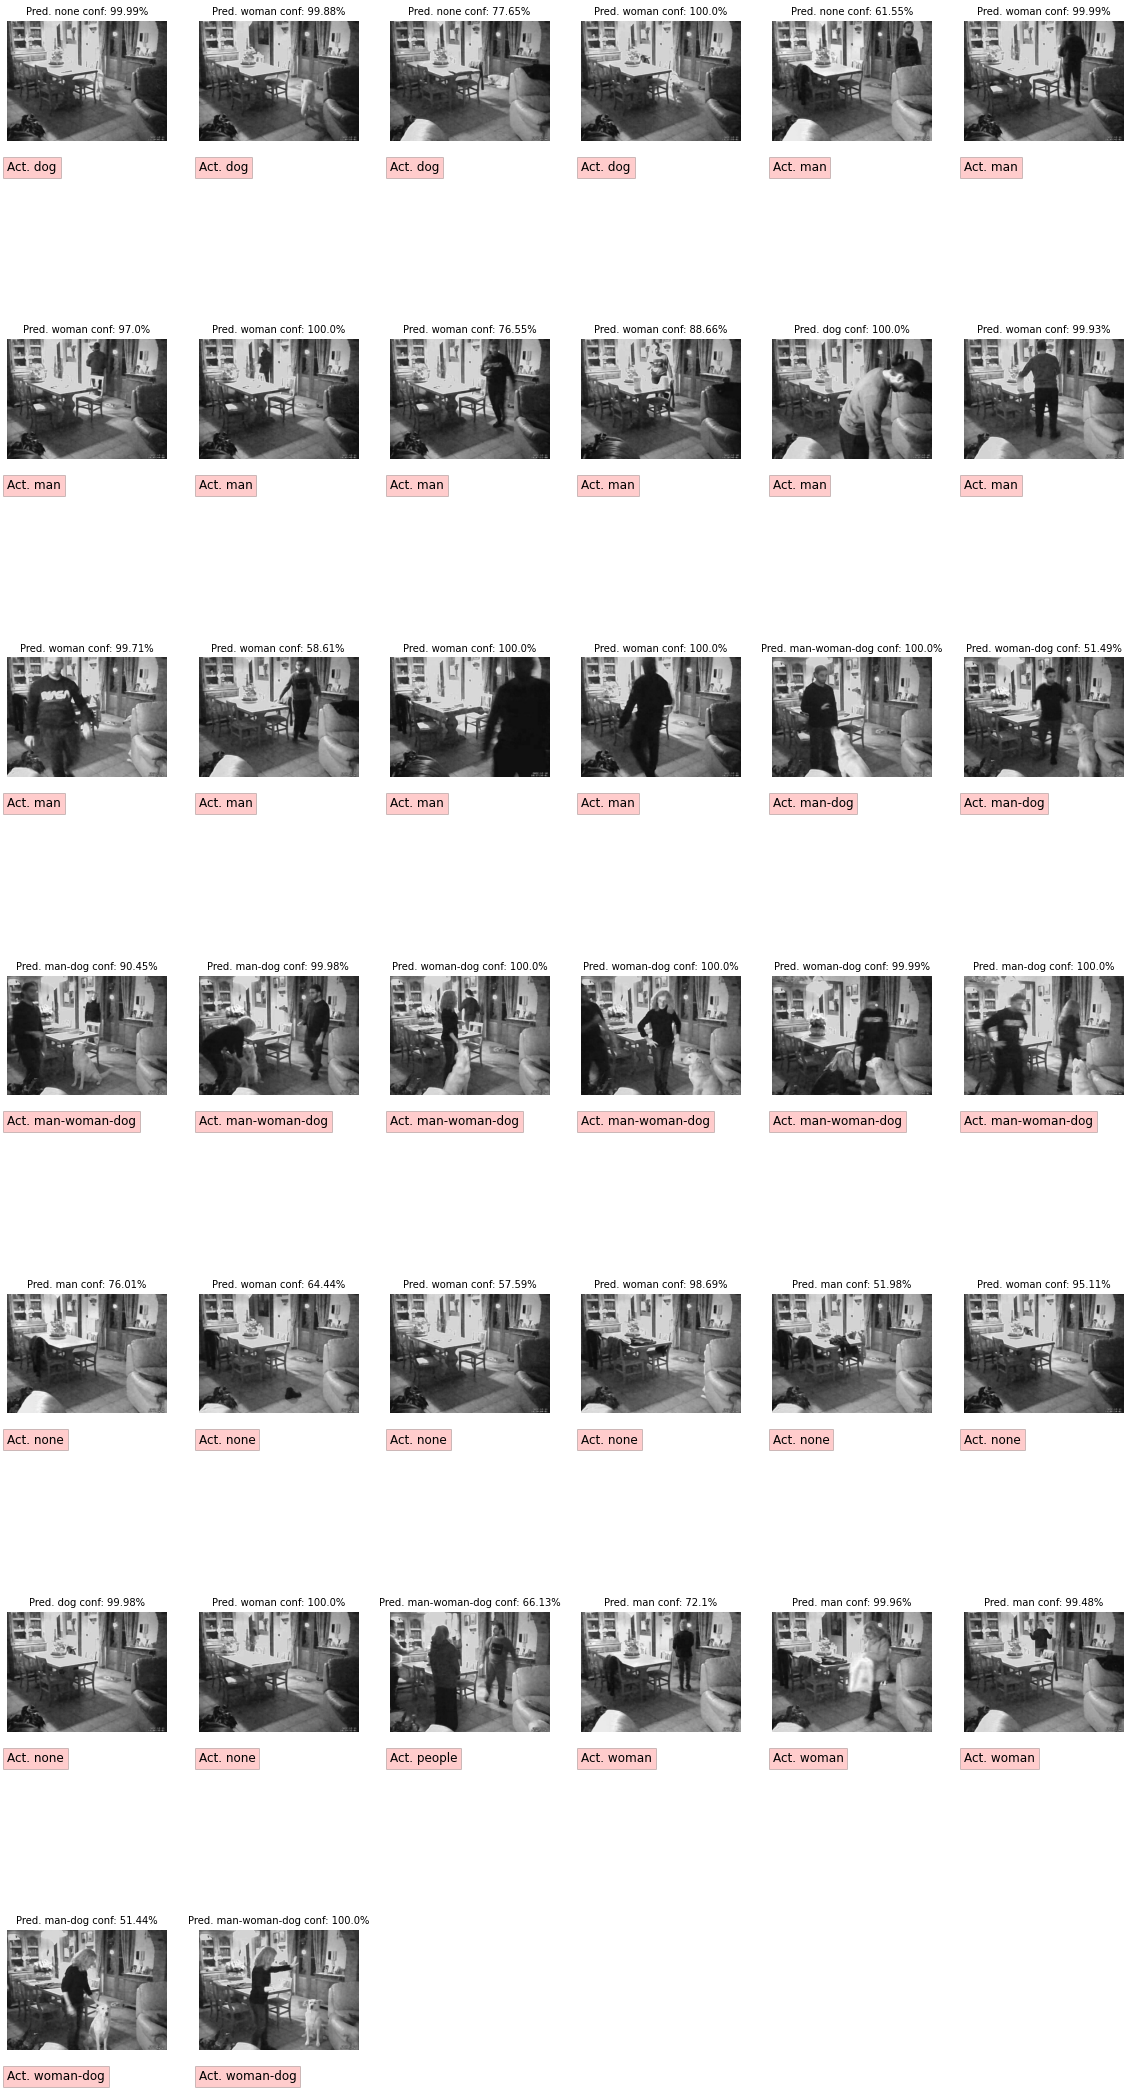

In [ ]:
statErrors(test_dataset,predictions,False,True)

In this second attempt the value of loss is reduced a lot both in validation than in test sets. However, the value of accuracy is lower too. Looking at the training behaviour, there is a non-evident situation of overfitting. Even at iteration 46 the model seems to try to reduce its loss but unfortunately due to reaching the maximum training epoch, the model stops the training early. So, the solutions could be to repeat the training  with a greater number of epochs and/or choosing a greater initial learning rate in order to speed up the convergence. If results are same could be interesting to improve the fully connected part, adding more dense layers with more neurons. 
Although these aspects, it can be considered an acceptable result. 

## Fine Tuning
In this section the Xception model is used to apply another transfer learning techniques: fine tuning. The idea is to freeze layers of the pre-trained network, like in feature extraction, leaving one or some of the last layers unfrozen in order to train both the remaining layers and the fully connected classifier. The advantage is to reuse the weights of first layers (representing the generic features) computed on a larger dataset and at the same time, training the weights of the last’s final layers (representing more specific features) adapting the new network to the custom task.
The approach adopted in the following experiments is to gradually unfreeze layers starting from the bottom, the more specific one, then looking the obtained result and repeat the operation with the new last remaining frozen layer. 


In [ ]:
def createPreTrained():
  return keras.applications.Xception(
    include_top=False,
    input_shape=(480, 640, 3),
    weights="imagenet",
    pooling="max"
  )

In [ ]:
#Just to have a complete picture of the entire Xception architecture
createPreTrained().summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 239, 319, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 239, 319, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
#Define model structure
#freezingLayerName = the name of the layer from which all the next layers are frozen.
def createModelFineTuning(freezingLayerName):
  
  inputs = keras.Input(shape=(480, 640, 3))
  
  preTrained=createPreTrained()
  
  x = preTrained(inputs)
  x = layers.Flatten()(x)
  outputs = layers.Dense(9, activation='softmax')(x)

  #Here the part for freezing from some layer on
  preTrained.trainable = True

  set_trainable = False
  for layer in preTrained.layers:
    #if "BatchNorm" in layer.name:
        #continue

    if layer.name == freezingLayerName:
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

  model = keras.Model(inputs, outputs)
  return model

### Experiment 3: unfreeze last layer

The model used in the first attempt is the same used in previous experiment: Xception with max-pooling layer. In the first attempt the last trainable layer block14_sepconv2_bn (Batch Normalization) is unfrozen. The reason why the block14_sepconv2_act is not taken in consideration is because is being used as a placeholder layer and it is designed to have no trainable parameters.

In [ ]:
#Istantiate the model
model=createModelFineTuning('block14_sepconv2_bn')

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 20,879,921
Trainable params: 22,537
Non-trainable params: 20,857,384
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Define a callback
custom_callback=createCustomCallback(os.path.join(MODEL_PATH, 'PreTrainedCNNModel_3.h5'),'val_loss')  

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks = custom_callback
)
#Save history obtained in history folder
with open(HISTORY_PATH+'/history4_3Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 3.5026 - accuracy: 0.3251
Epoch 1: val_loss improved from inf to 1.56390, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_3.h5
99/99 [==============================] - 395s 4s/step - loss: 3.5026 - accuracy: 0.3251 - val_loss: 1.5639 - val_accuracy: 0.4119
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 1.2433 - accuracy: 0.5537
Epoch 2: val_loss improved from 1.56390 to 1.26424, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_3.h5
99/99 [==============================] - 117s 1s/step - loss: 1.2433 - accuracy: 0.5537 - val_loss: 1.2642 - val_accuracy: 0.6296
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.9389 - accuracy: 0.6784
Epoch 3: val_loss improved from 1.26424 to 0.71561, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_3.h5
99/99 [==============================] - 116s 1s/step - loss: 0.9389 - accuracy: 

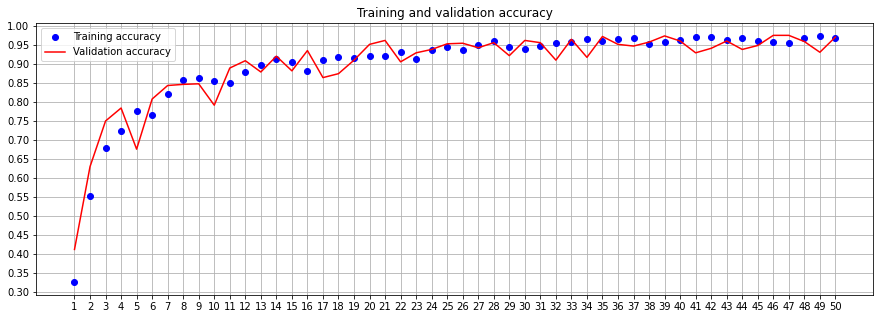

<Figure size 432x288 with 0 Axes>

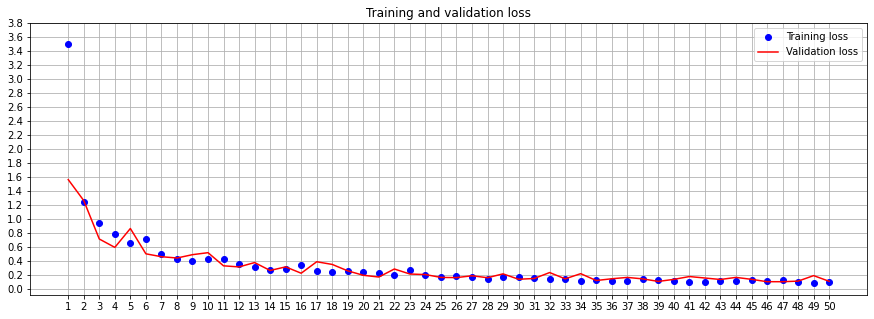

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history4_3Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 

plotAccuracyAndLossCurves(historySaved,np.arange(1, EPOCHS+1, 1),np.arange(0.3, 1+0.05, 0.05),np.arange(1, EPOCHS+1, 1),np.arange(0, 4, 0.2))

In [ ]:
model = load_model(MODEL_PATH+"/PreTrainedCNNModel_3.h5") 
predictions = model.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model.evaluate(test_dataset)

22/22 [==============================] - 23s 1s/step - loss: 0.1478 - accuracy: 0.9511


Total errors :33/675


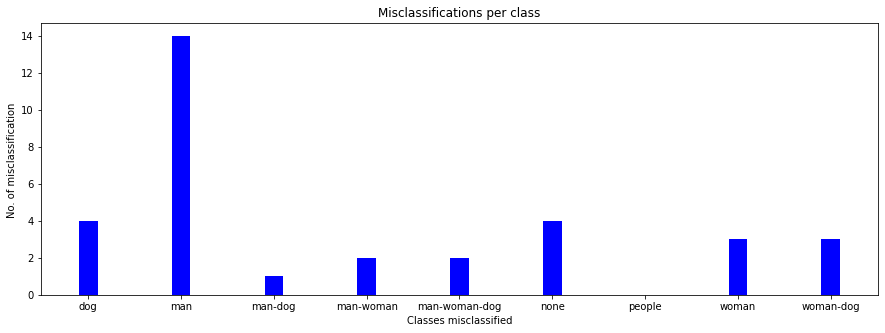

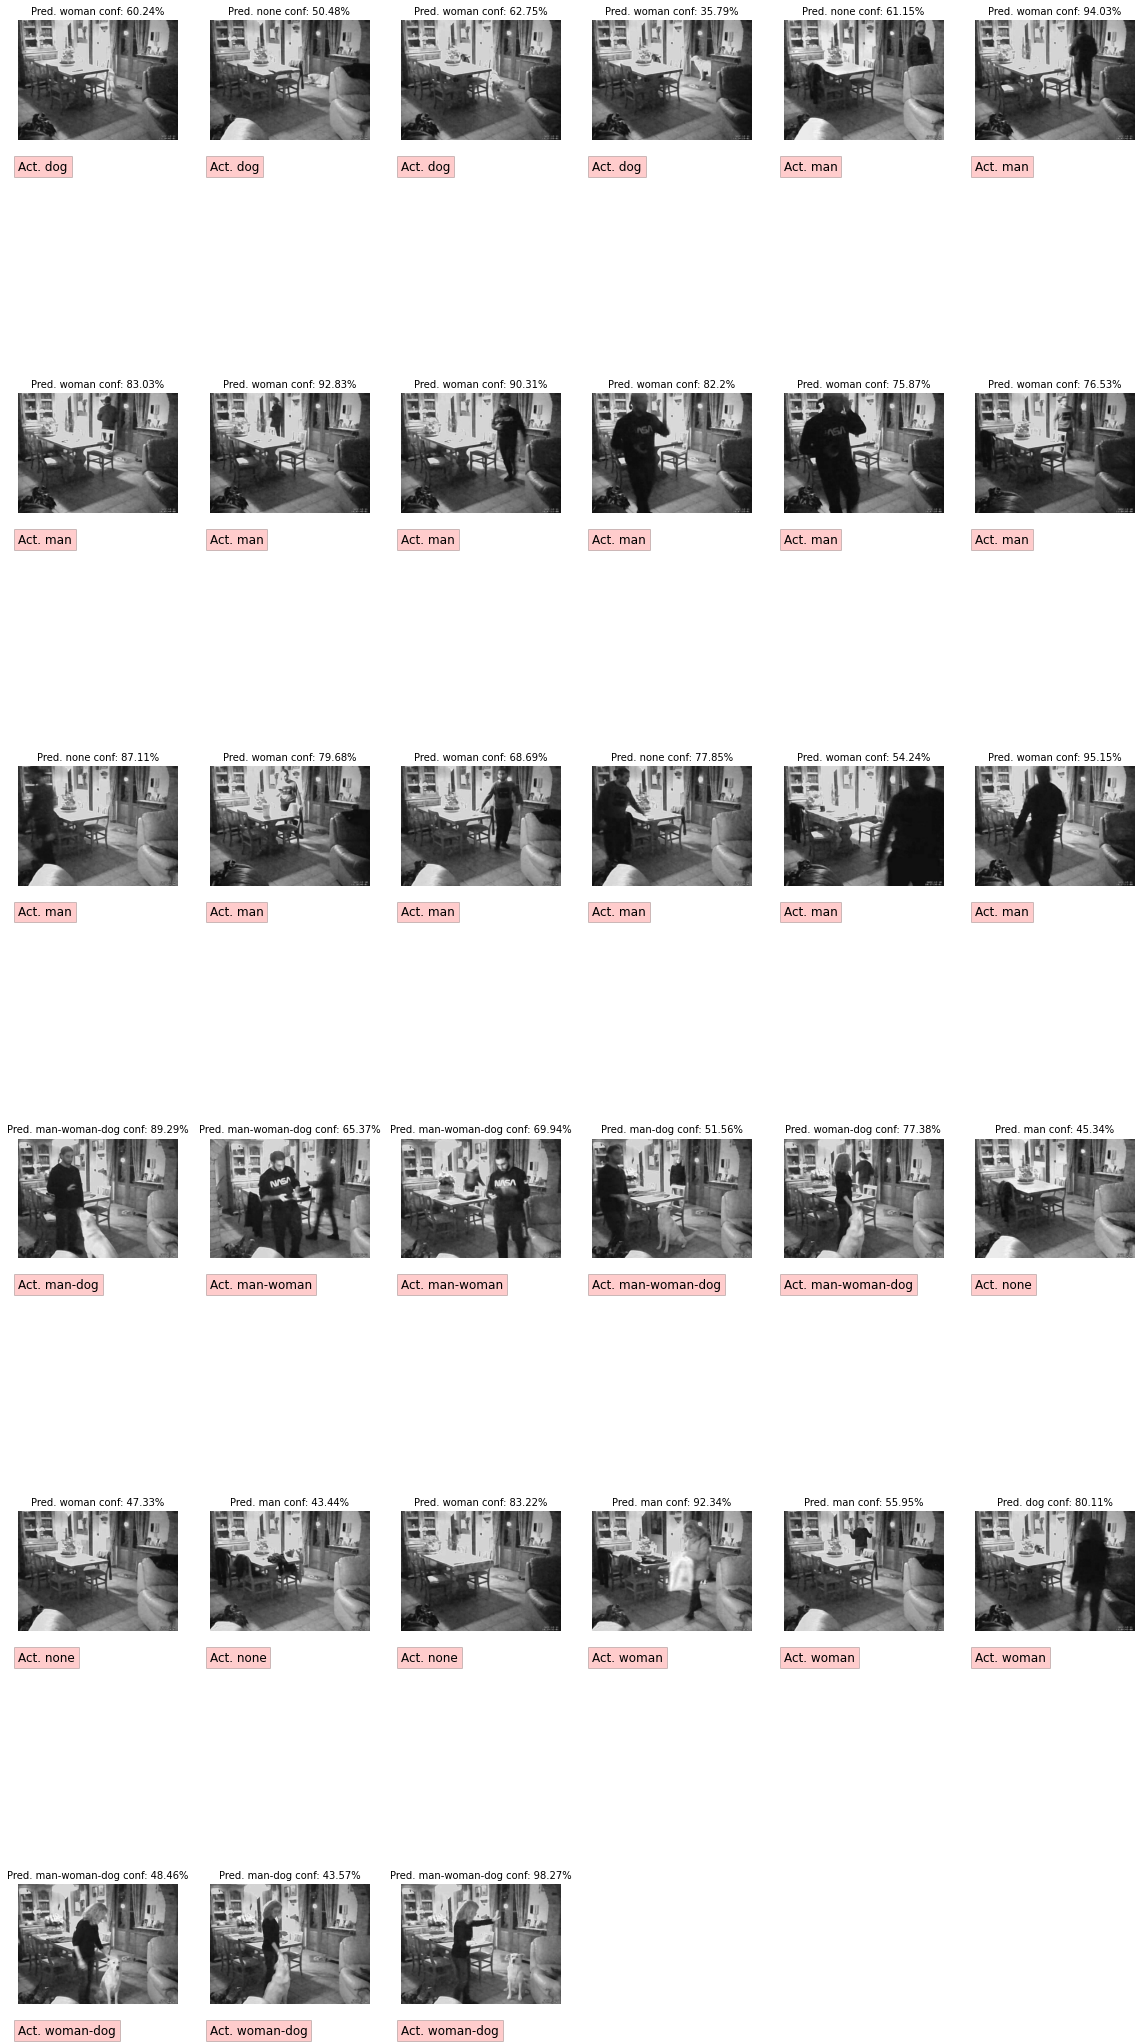

In [ ]:
statErrors(test_dataset,predictions,False,True)

Looking at the training results, the model evidence a slow convergence and an interesting aspect: in most of the epochs the validation accuracy is bigger (a little) then the training accuracy. 

### Experiment 4: unfreeze last two layers
In the second attempt the last two trainable layers are unfrozen: block14_sepconv2 (Separable Convolution 2D) and block14_sepconv2_bn (Batch Normalization). The total number of trainable parameters is 3 182 089, slightly bigger respect to previous attempt but the risk of overfitting is limited due to the presence of big data available.

In [ ]:
#Istantiate the model
model=createModelFineTuning('block14_sepconv2')

model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 9)                 18441     
                                                                 
Total params: 20,879,921
Trainable params: 3,182,089
Non-trainable params: 17,697,832
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Define a callback
custom_callback=createCustomCallback(os.path.join(MODEL_PATH, 'PreTrainedCNNModel_4.h5'),'val_loss')  

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks = custom_callback
)
#Save history obtained in history folder
with open(HISTORY_PATH+'/history4_4Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 2.3866 - accuracy: 0.6162
Epoch 1: val_loss improved from inf to 0.33867, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_4.h5
99/99 [==============================] - 284s 3s/step - loss: 2.3866 - accuracy: 0.6162 - val_loss: 0.3387 - val_accuracy: 0.8904
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.8975
Epoch 2: val_loss improved from 0.33867 to 0.20916, saving model to /content/drive/MyDrive/CIDL/models/PreTrainedCNNModel_4.h5
99/99 [==============================] - 114s 1s/step - loss: 0.2913 - accuracy: 0.8975 - val_loss: 0.2092 - val_accuracy: 0.9333
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.9225
Epoch 3: val_loss did not improve from 0.20916
99/99 [==============================] - 119s 1s/step - loss: 0.2432 - accuracy: 0.9225 - val_loss: 0.4430 - val_accuracy: 0.8933
Epoch 4/50
99/99 [=============

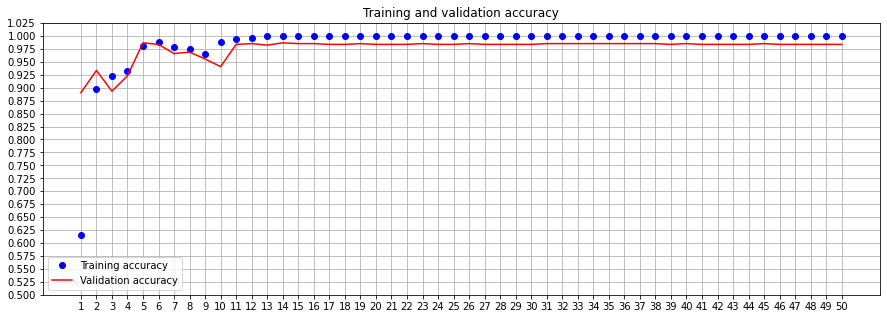

<Figure size 432x288 with 0 Axes>

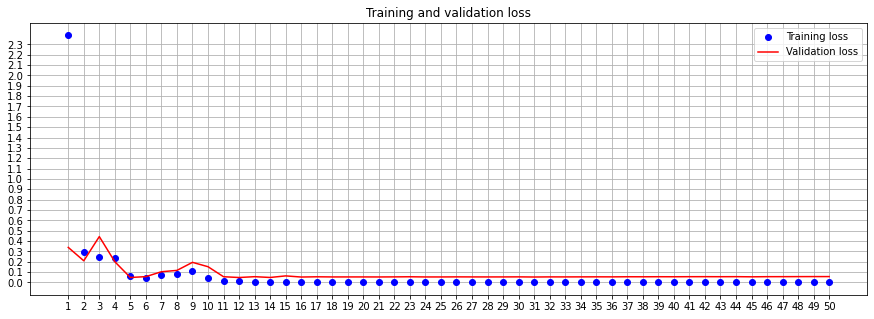

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history4_4Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 

plotAccuracyAndLossCurves(historySaved,np.arange(1, EPOCHS+1, 1),np.arange(0.5, 1+0.05, 0.025),np.arange(1, EPOCHS+1, 1),np.arange(0, 2.4, 0.1))

In [ ]:
model = load_model(MODEL_PATH+"/PreTrainedCNNModel_4.h5") 
predictions = model.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model.evaluate(test_dataset)

22/22 [==============================] - 20s 864ms/step - loss: 0.0844 - accuracy: 0.9822


Total errors :12/675


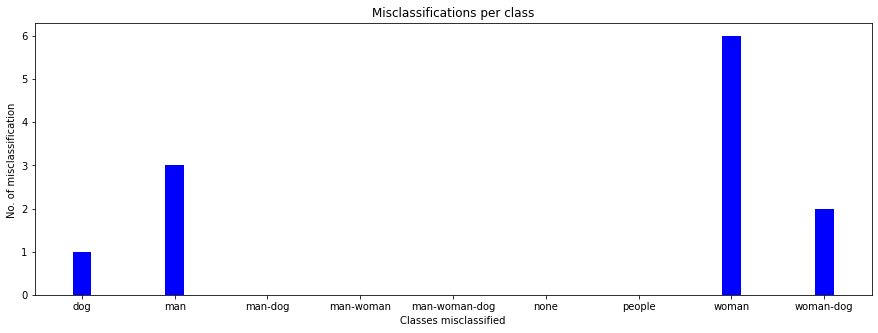

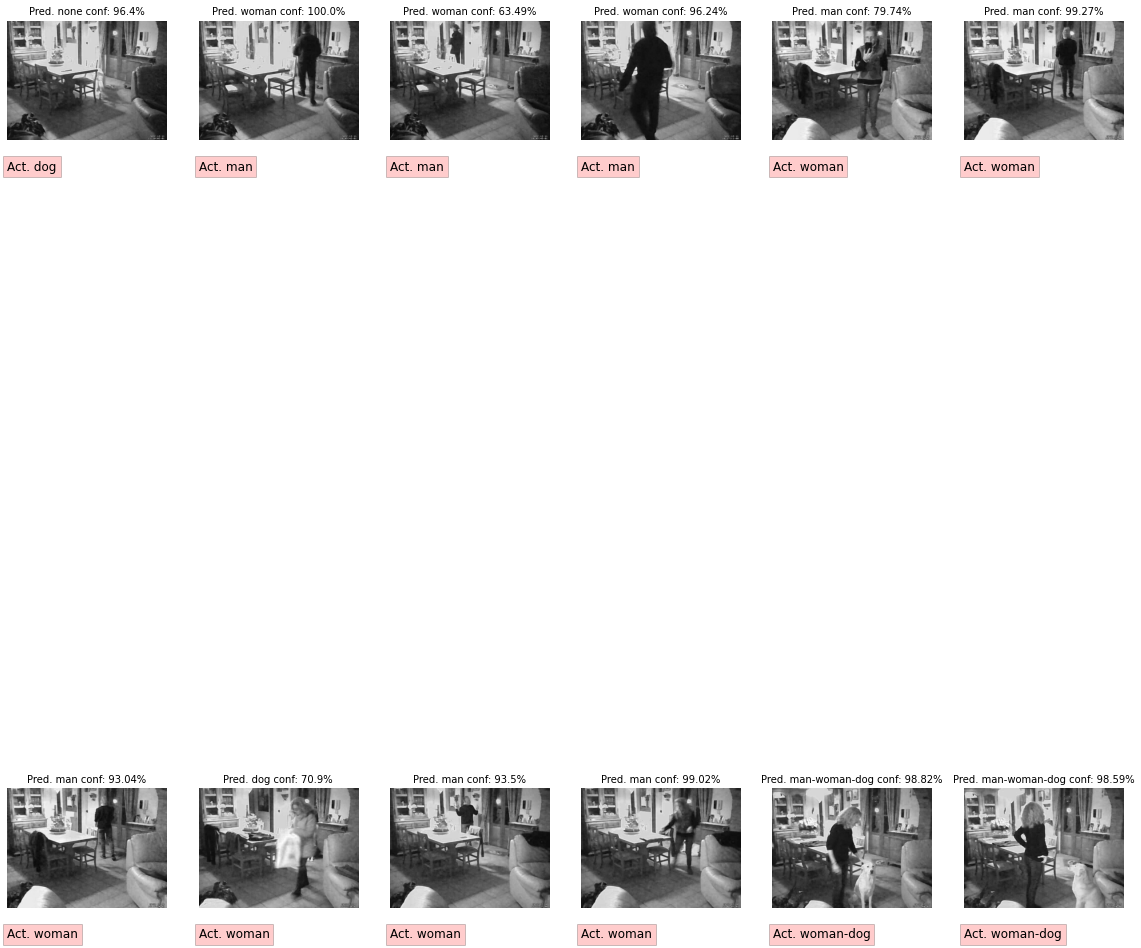

In [ ]:
statErrors(test_dataset,predictions,False,True)

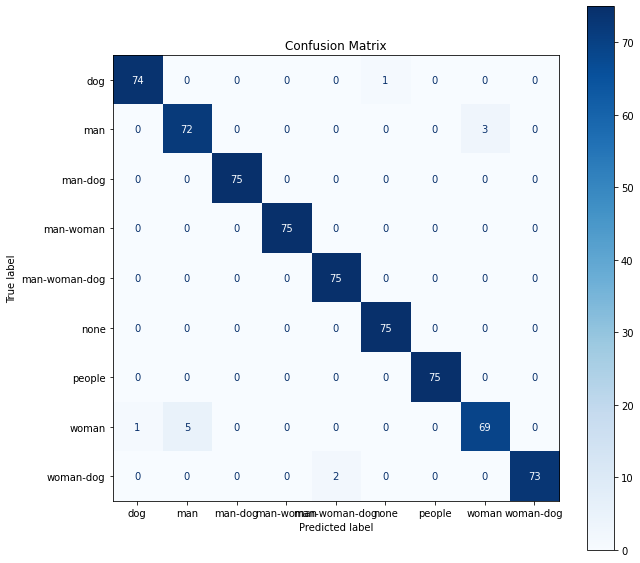

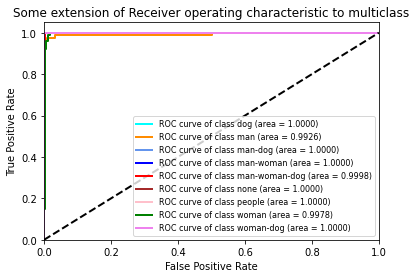

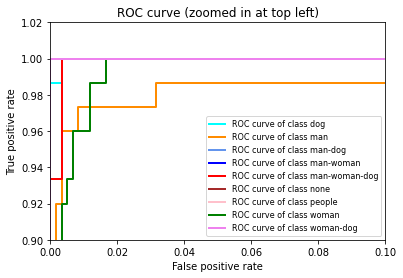

In [ ]:
evalutation_performance(test_dataset,predictions)

In this experiment, the convergence is very fast and reaches very good results. This represents the best result obtained using Xception pre-trained network despite it requires to train more parameters so more training time. Using the fine-tuning technique, the performances result improved respect to feature extraction because unfreezing the last layers the domain problem tends to be resolved making the network adapting to new custom problem.